In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import ROOT
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial


Welcome to JupyROOT 6.10/04


In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
from decode_new import GetWaveformsNoiseRemoval

In [4]:
from datetime import datetime

In [5]:
def gettime(name):
    date = name.split('PrM1-')[-1].split('.dat')[0]
    time = datetime.strptime(date,'%Y_%m_%d-%H_%M_%S')
    return time

In [6]:
def QaQc(wf_v):
    anode_v = wf_v[0][700:]
    cathode_v = wf_v[1][500:]
    Qa = np.amax(anode_v)
    Qc = np.amin(cathode_v)
    return Qa,Qc

def QaQcSTATS(ev_wf_v):
    
    Qa_v = []
    Qc_v = []
    for wf_v in ev_wf_v:
        Qa,Qc = QaQc(wf_v)
        Qa_v.append(Qa*1e3)
        Qc_v.append(Qc*1e3)
    Qa_v = np.array(Qa_v)
    Qc_v = np.array(Qc_v)

    Qa_avg = np.mean(Qa_v)
    Qa_rms = np.std(Qa_v)
    Qc_avg = np.mean(Qc_v)
    Qc_rms = np.std(Qc_v)
    
    return [[Qa_avg,Qa_rms],[Qc_avg,Qc_rms]]

In [7]:
#PATH = '/home/david/data/PrM/Gas07psi_092718/'
#PATH = '/home/david/data/PrM/7psi/data7psi/data/'
#PATH = '/home/david/data/PrM/Run2Liquid/Liquid/VC100_VCG65/measures/'

#PATH = '/home/david/data/LArCADeGAS2019/2PSI/'
PATH = '/home/david/data/LArCADe012020/'


datafile_v = os.listdir(PATH)
dt = 0.0005

In [8]:
VoltageMap = {'11_37_11':2,'11_36_22':2,'11_34_52':6,'11_34_18':6,'11_33_06':6,'11_32_15':6,\
             '11_30_58':3,'11_30_25':3,'11_29_23':3,'11_28_13':3,'11_27_16':3.5,'11_26_39':3.5,\
             '11_26_08':3.5,'11_24_25':3.5,'11_23_25':3.5,'11_22_37':4,'11_22_05':4,'11_21_15':4,\
             '11_20_35':4,'11_19_58':4,'11_19_01':5,'11_18_29':5,'11_16_26':5,'11_13_23':5,\
             '10_05_15':6,'10_03_55':6,'09_58_46':6,'09_56_14':6,'09_53_44':6,'09_52_27':5,\
             '09_51_04':5,'09_49_32':5,'09_48_03':5,'09_46_19':5,'09_45_30':5,'09_44_28':4,\
             '09_43_36':4,'09_42_29':4,'09_41_18':3}

In [9]:
def getDataFile(date):
    found = False
    for i,datafile in enumerate(datafile_v):
        if (datafile.find(date) > 0):
            return i
    return None

In [10]:
for i,datafile in enumerate(datafile_v):
    print '%i -> %s'%(i,datafile)

0 -> PrM1-2020_01_29-11_21_15.dat
1 -> PrM1-2020_01_29-11_37_11.dat
2 -> PrM1-2020_01_29-11_26_39.dat
3 -> PrM1-2020_01_29-09_53_44.dat
4 -> PrM1-2020_01_29-10_05_15.dat
5 -> PrM1-2020_01_29-09_30_45.dat
6 -> PrM1-2020_01_29-09_31_51.dat
7 -> PrM1-2020_01_29-11_22_05.dat
8 -> PrM1-2020_01_29-11_30_25.dat
9 -> PrM1-2020_01_29-09_42_29.dat
10 -> PrM1-2020_01_29-11_19_58.dat
11 -> PrM1-2020_01_29-11_18_29.dat
12 -> larcade_29_01_20_-_04
13 -> larcade_29_01_20_-_01
14 -> PrM1-2020_01_29-11_26_08.dat
15 -> larcade_run_01_29_2020_-_00
16 -> PrM1-2020_01_29-09_49_32.dat
17 -> larcade_29_01_20_-_03
18 -> PrM1-2020_01_29-11_13_23.dat
19 -> PrM1-2020_01_29-11_30_58.dat
20 -> PrM1-2020_01_29-09_44_28.dat
21 -> PrM1-2020_01_29-10_03_55.dat
22 -> PrM1-2020_01_29-09_41_18.dat
23 -> PrM1-2020_01_29-11_34_52.dat
24 -> PrM1-2020_01_29-11_20_35.dat
25 -> PrM1-2020_01_29-11_16_26.dat
26 -> PrM1-2020_01_29-11_22_37.dat
27 -> PrM1-2020_01_29-11_27_16.dat
28 -> PrM1-2020_01_29-09_56_14.dat
29 -> PrM1-2020_0

In [11]:
date = '11_34_52'
nfile = getDataFile(date)
if (nfile != None):
    datafile = PATH + datafile_v[nfile]
    print datafile
    ev_wf_v = GetWaveformsNoiseRemoval(datafile)
else:
    print 'no input file found!'

/home/david/data/LArCADe012020/PrM1-2020_01_29-11_34_52.dat
dt is  0.0005


In [12]:
time_v = np.linspace(0,dt*len(ev_wf_v[0][0]),len(ev_wf_v[0][0]))

In [13]:
avg_A_wf_v = np.zeros(len(time_v))
avg_C_wf_v = np.zeros(len(time_v))
for n in xrange(len(ev_wf_v)):
    avg_A_wf_v += ev_wf_v[n][0]
    avg_C_wf_v += ev_wf_v[n][1]
avg_A_wf_v /= len(ev_wf_v)
avg_C_wf_v /= len(ev_wf_v)

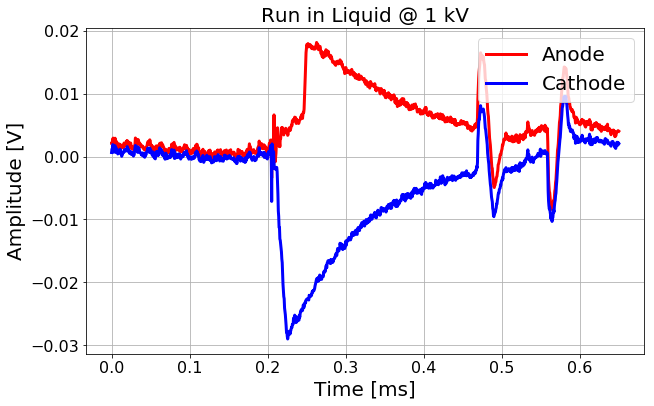

In [14]:
fig = plt.figure(figsize=(10,6))
plt.plot(time_v,avg_A_wf_v,color='r',label='Anode',lw=3)
plt.plot(time_v,avg_C_wf_v,color='b',label='Cathode',lw=3)
plt.grid()
plt.legend(loc=1,fontsize=20)
plt.xlabel('Time [ms]',fontsize=20)
plt.ylabel('Amplitude [V]',fontsize=20)
plt.title('Run in Liquid @ 1 kV',fontsize=20)
#plt.ylim([-0.025,0.025])
#plt.xlim([0.1,1.3])

plt.show()

In [15]:
dt = 0.0005

Tmin = 0.1# ms
Tmax = 0.6 # ms

BaselineRange1 = [0.10,0.15]
BaselineRange2 = [0.18,0.20]

IntegrationRange = [0.2,0.6]

B1Tmin = int(BaselineRange1[0]/dt)
B1Tmax = int(BaselineRange1[1]/dt)

B2Tmin = int(BaselineRange2[0]/dt)
B2Tmax = int(BaselineRange2[1]/dt)

IntMin = int(IntegrationRange[0]/dt)
IntMax = int(IntegrationRange[1]/dt)


VOLTAGE_V = []
# amplitude
CATHODE_V = []
ANODE_V = []
# amplitude
CATHODE_V_D = {}
ANODE_V_D = {}
CATHODE_V_D[2000] = []
CATHODE_V_D[3000] = []
CATHODE_V_D[3500] = []
CATHODE_V_D[4000] = []
CATHODE_V_D[5000] = []
CATHODE_V_D[6000] = []
ANODE_V_D[2000] = []
ANODE_V_D[3000] = []
ANODE_V_D[3500] = []
ANODE_V_D[4000] = []
ANODE_V_D[5000] = []
ANODE_V_D[6000] = []
# area
CATHODE_A = []
ANODE_A = []
CATHODE_A_D = {}
ANODE_A_D = {}
CATHODE_A_D[2000] = []
CATHODE_A_D[3000] = []
CATHODE_A_D[3500] = []
CATHODE_A_D[4000] = []
CATHODE_A_D[5000] = []
CATHODE_A_D[6000] = []
ANODE_A_D[2000] = []
ANODE_A_D[3000] = []
ANODE_A_D[3500] = []
ANODE_A_D[4000] = []
ANODE_A_D[5000] = []
ANODE_A_D[6000] = []
# time
CATHODE_T = []
ANODE_T = []
# waveforms
WF_A_D = {}
WF_A_D[2000] = []
WF_A_D[3000] = []
WF_A_D[3500] = []
WF_A_D[4000] = []
WF_A_D[5000] = []
WF_A_D[6000] = []
WF_C_D = {}
WF_C_D[2000] = []
WF_C_D[3000] = []
WF_C_D[3500] = []
WF_C_D[4000] = []
WF_C_D[5000] = []
WF_C_D[6000] = []

for date,voltage in VoltageMap.iteritems():

    nfile = getDataFile(date)
    datafile = PATH + datafile_v[nfile]
    ev_wf_v = GetWaveformsNoiseRemoval(datafile)

    for n in xrange(len(ev_wf_v)):

        cathode_wf = ev_wf_v[n][1]
        anode_wf   = ev_wf_v[n][0]
        
        # compute baselines
        B1C = 1e3*np.mean(cathode_wf[B1Tmin:B1Tmax])
        B2C = 1e3*np.mean(cathode_wf[B2Tmin:B2Tmax])
        B1A = 1e3*np.mean(anode_wf[B1Tmin:B1Tmax])
        B2A = 1e3*np.mean(anode_wf[B2Tmin:B2Tmax])
        print (r'baseline C1 : %.02f C2 : %.02f A1 : %.02f A2 : %.02f [$\mu$ V]'%(B1C,B2C,B1A,B2A))
        
        if ( (np.abs(B1C-B2C) > 2) or (np.abs(B1A-B2A) > 2) ):
            continue

        # average baselines
        BA = (B1A+B2A)/2.
        BC = (B1C+B2C)/2.   
            
        # trim waveforms
        cathode_wf = cathode_wf[ int(Tmin/dt) : int(Tmax/dt) ]
        anode_wf = anode_wf[ int(Tmin/dt) : int(Tmax/dt) ]
        
        time_v = np.linspace(Tmin,Tmax,len(anode_wf))
        
        cathodeminV = 1e3*np.amin(cathode_wf)
        cathodeminT = np.argmin(cathode_wf)
        
        anodemaxV = 1e3*np.amax(anode_wf)
        anodemaxT = np.argmax(anode_wf)
        

        # peak times
        PTA = anodemaxT*dt+Tmin
        PTC = cathodeminT*dt+Tmin
        
        if (PTA > 0.27 or PTA < 0.25):
            continue
        if (PTC > 0.235 or PTC < 0.22):
            continue
            
        MAXA = anodemaxV-BA
        MAXC = cathodeminV-BC

        
        AREAC = np.sum(cathode_wf[IntMin:IntMax]) -(BC/1e3 * (IntMax-IntMin))
        AREAA = np.sum(anode_wf[IntMin:IntMax]  ) - (BA/1e3 * (IntMax-IntMin))
        
        
        print 'Peak A : %.02f @ Time %.02f. Peak C : %.02f @ Time %.02f'%(MAXA,PTA,MAXC,PTC)
        print 'Area A : %.02f Area C : %.02f'%(AREAA,AREAC)
        
        VOLTAGE_V.append(voltage*1e3)
        ANODE_V.append(MAXA)
        ANODE_T.append(PTA)
        ANODE_A.append(AREAA)
        CATHODE_V.append(np.abs(MAXC))
        CATHODE_T.append(PTC)
        CATHODE_A.append(AREAC)
        
        
        CATHODE_V_D[int(voltage*1e3)].append(np.abs(MAXC))
        ANODE_V_D[int(voltage*1e3)].append(np.abs(MAXA))
        
        CATHODE_A_D[int(voltage*1e3)].append(np.abs(AREAC))
        ANODE_A_D[int(voltage*1e3)].append(np.abs(AREAA))        
        
        WF_A_D[int(voltage*1e3)].append(np.array(anode_wf)-B1A/1e3)
        WF_C_D[int(voltage*1e3)].append(np.array(cathode_wf)-B1C/1e3)
        
        continue
        
        fig = plt.figure(figsize=(10,6))
        plt.plot(time_v,anode_wf,color='r',label='Anode')
        plt.plot(time_v,cathode_wf,color='b',label='Cathode')
        #plt.plot(time_v,(anode_wf-cathode_wf),color='g',label='C-A')
        plt.grid()
        plt.legend(loc=2,fontsize=20)
        plt.xlabel('Time [ms]',fontsize=20)
        plt.ylabel('Amplitude [mV]',fontsize=20)
        plt.xlim([Tmin,Tmax])
        #plt.ylim([-0.04,0.04])
        plt.title('%0.f V @ Anode - file %s'%(voltage*1e3,date))
        plt.savefig('plots/voltage_%04i_time_%s_%02i.png'%(voltage*1e3,date,n))
        #plt.ylim([-0.025,0.025])
        #plt.xlim([0.18,0.5])
        plt.show()
        break

dt is  0.0005
baseline C1 : -12.17 C2 : -7.72 A1 : -0.13 A2 : 4.62 [$\mu$ V]
baseline C1 : -9.06 C2 : -8.98 A1 : -3.12 A2 : -3.31 [$\mu$ V]
Peak A : 10.93 @ Time 0.26. Peak C : -30.39 @ Time 0.23
Area A : 0.59 Area C : -2.78
baseline C1 : 6.54 C2 : 13.44 A1 : -5.95 A2 : 1.69 [$\mu$ V]
dt is  0.0005
baseline C1 : 6.12 C2 : 6.57 A1 : -2.02 A2 : -1.46 [$\mu$ V]
baseline C1 : 7.31 C2 : 7.66 A1 : 5.54 A2 : 5.39 [$\mu$ V]
Peak A : 7.38 @ Time 0.27. Peak C : -32.10 @ Time 0.23
Area A : -4.20 Area C : -9.19
baseline C1 : 3.39 C2 : 3.15 A1 : 0.96 A2 : 0.51 [$\mu$ V]
baseline C1 : -5.85 C2 : -5.69 A1 : 2.54 A2 : 2.90 [$\mu$ V]
baseline C1 : 0.87 C2 : 1.78 A1 : -4.07 A2 : -3.07 [$\mu$ V]
baseline C1 : 2.42 C2 : 1.96 A1 : 4.26 A2 : 4.06 [$\mu$ V]
Peak A : 10.10 @ Time 0.26. Peak C : -31.19 @ Time 0.23
Area A : -3.19 Area C : -8.29
baseline C1 : -7.97 C2 : -6.46 A1 : -0.80 A2 : 0.77 [$\mu$ V]
Peak A : 11.69 @ Time 0.26. Peak C : -29.99 @ Time 0.23
Area A : 2.17 Area C : -1.85
baseline C1 : -2.94 C2

baseline C1 : -3.19 C2 : -3.44 A1 : -1.31 A2 : -1.27 [$\mu$ V]
Peak A : 9.79 @ Time 0.26. Peak C : -24.32 @ Time 0.23
Area A : 1.47 Area C : -2.40
baseline C1 : 4.47 C2 : 4.38 A1 : 3.98 A2 : 3.88 [$\mu$ V]
Peak A : 9.65 @ Time 0.25. Peak C : -23.47 @ Time 0.23
Area A : 0.18 Area C : -3.75
baseline C1 : -0.33 C2 : 1.73 A1 : 8.56 A2 : 10.54 [$\mu$ V]
dt is  0.0005
baseline C1 : 9.39 C2 : -5.60 A1 : -8.89 A2 : -25.98 [$\mu$ V]
baseline C1 : -5.43 C2 : -10.10 A1 : -3.55 A2 : -8.26 [$\mu$ V]
baseline C1 : 0.27 C2 : -0.50 A1 : 12.19 A2 : 10.88 [$\mu$ V]
baseline C1 : -7.14 C2 : -7.40 A1 : 2.44 A2 : 1.83 [$\mu$ V]
Peak A : 13.68 @ Time 0.25. Peak C : -31.45 @ Time 0.23
Area A : 0.67 Area C : -2.61
baseline C1 : -15.22 C2 : -15.65 A1 : -4.90 A2 : -5.26 [$\mu$ V]
baseline C1 : 8.34 C2 : 8.52 A1 : 3.95 A2 : 4.23 [$\mu$ V]
baseline C1 : -4.91 C2 : -3.54 A1 : -12.21 A2 : -10.39 [$\mu$ V]
Peak A : 17.50 @ Time 0.25. Peak C : -28.88 @ Time 0.23
Area A : 8.44 Area C : 1.22
baseline C1 : -6.88 C2 : -2

baseline C1 : -3.87 C2 : -4.64 A1 : -2.31 A2 : -3.02 [$\mu$ V]
baseline C1 : 1.18 C2 : 0.96 A1 : -2.20 A2 : -2.34 [$\mu$ V]
Peak A : 5.15 @ Time 0.26. Peak C : -20.70 @ Time 0.23
Area A : 1.26 Area C : -2.67
baseline C1 : 0.32 C2 : 0.16 A1 : 1.10 A2 : 0.88 [$\mu$ V]
Peak A : 7.02 @ Time 0.26. Peak C : -20.51 @ Time 0.23
Area A : 0.71 Area C : -2.60
baseline C1 : 4.93 C2 : 1.22 A1 : 7.43 A2 : 3.36 [$\mu$ V]
dt is  0.0005
baseline C1 : 6.30 C2 : 5.90 A1 : 0.22 A2 : -0.12 [$\mu$ V]
baseline C1 : -5.53 C2 : -5.70 A1 : -1.82 A2 : -1.99 [$\mu$ V]
Peak A : 10.25 @ Time 0.26. Peak C : -30.81 @ Time 0.23
Area A : 1.66 Area C : -2.73
baseline C1 : -6.21 C2 : -5.04 A1 : 1.15 A2 : 1.90 [$\mu$ V]
dt is  0.0005
baseline C1 : 0.47 C2 : 0.63 A1 : 2.93 A2 : 3.55 [$\mu$ V]
Peak A : 12.68 @ Time 0.25. Peak C : -31.60 @ Time 0.23
Area A : 1.57 Area C : -4.25
baseline C1 : -2.84 C2 : -2.55 A1 : -0.21 A2 : 0.23 [$\mu$ V]
baseline C1 : 6.27 C2 : 6.34 A1 : 5.28 A2 : 5.36 [$\mu$ V]
dt is  0.0005
baseline C1 : 

In [16]:
VOLTAGE_V = np.array(VOLTAGE_V)
CATHODE_V = np.array(CATHODE_V)
CATHODE_A = np.array(CATHODE_A)
ANODE_V = np.array(ANODE_V)
ANODE_A = np.array(ANODE_A)

In [17]:
def SMOOTH(wfin,N):
    wfout = []
    LEN = len(wfin)
    for i in range(2*N,LEN-2*N):
        wfout.append( np.average(wfin[i-N:i+N]) )
    #for i,adc in enumerate(wfin):
    return np.array(wfout)    

min cathode : -0.032
min cathode : -0.031
min cathode : -0.024
min cathode : -0.031
min cathode : -0.023
min cathode : -0.033
min cathode : -0.027
min cathode : -0.032


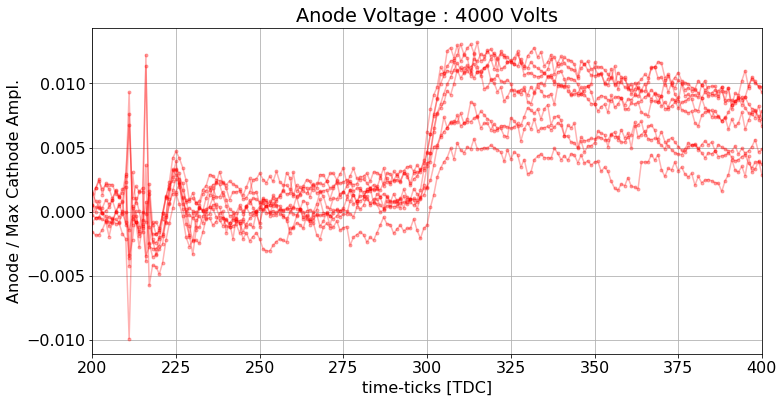

min cathode : -0.024
min cathode : -0.023
min cathode : -0.027
min cathode : -0.033
min cathode : -0.032
min cathode : -0.028
min cathode : -0.031
min cathode : -0.031
min cathode : -0.030
min cathode : -0.032
min cathode : -0.032
min cathode : -0.032
min cathode : -0.032
min cathode : -0.031
min cathode : -0.031
min cathode : -0.025
min cathode : -0.024
min cathode : -0.025


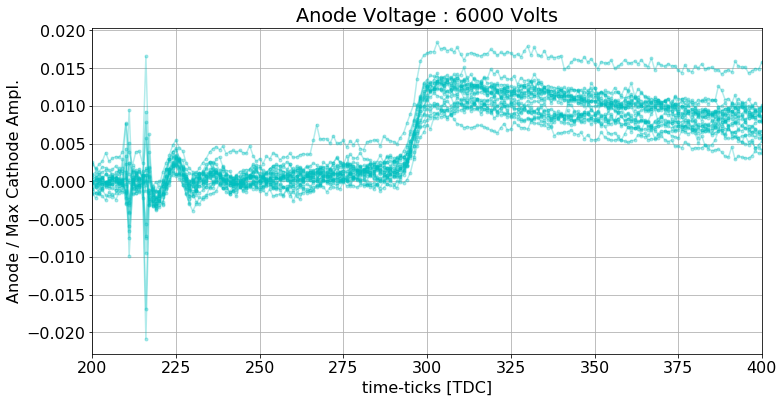

min cathode : -0.024
min cathode : -0.024
min cathode : -0.032
min cathode : -0.032
min cathode : -0.024
min cathode : -0.024
min cathode : -0.024
min cathode : -0.031
min cathode : -0.032
min cathode : -0.031
min cathode : -0.032
min cathode : -0.023


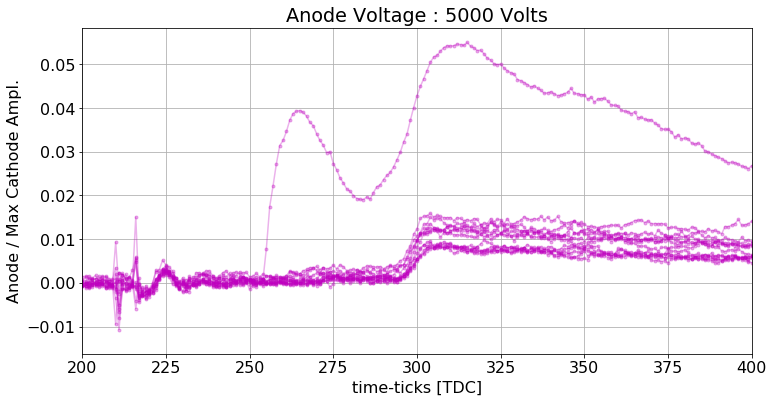

min cathode : -0.032
min cathode : -0.031
min cathode : -0.030
min cathode : -0.031
min cathode : -0.030


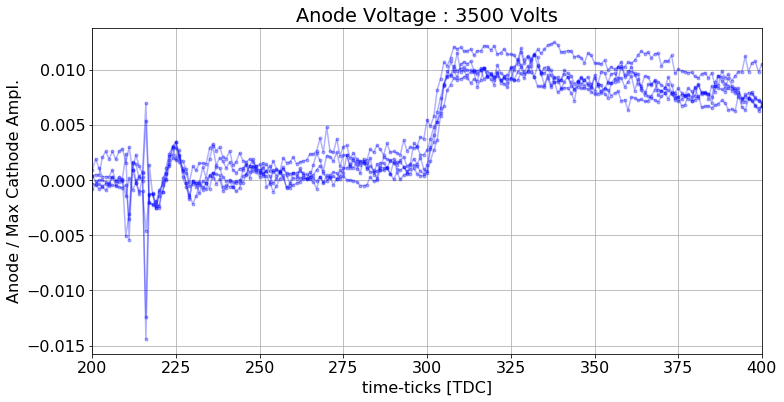

min cathode : -0.031
min cathode : -0.031
min cathode : -0.031
min cathode : -0.033


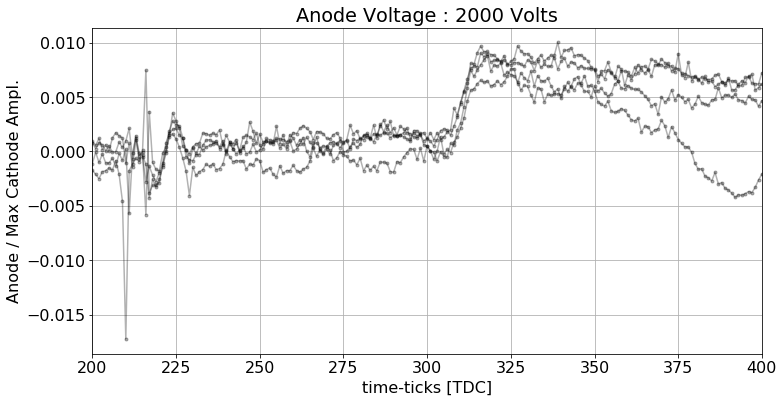

min cathode : -0.030
min cathode : -0.032
min cathode : -0.031
min cathode : -0.029
min cathode : -0.032
min cathode : -0.030
min cathode : -0.030
min cathode : -0.032
min cathode : -0.031
min cathode : -0.032
min cathode : -0.031
min cathode : -0.033
min cathode : -0.031
min cathode : -0.030
min cathode : -0.021
min cathode : -0.021
min cathode : -0.031


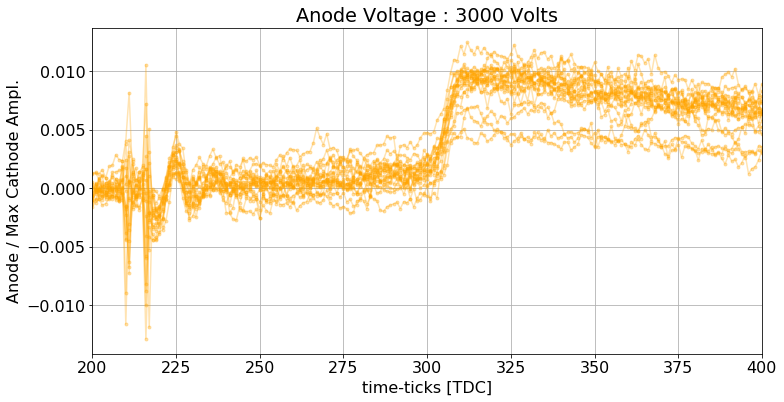

In [26]:
#fig = plt.figure(figsize=(10,8))


color_v = ['r','c','m','b','k','orange']

ctr = 0
for voltage,waveformsA in WF_A_D.items():
    
    fig = plt.figure(figsize=(12,6))

    waveformsC = WF_C_D[voltage]
    
    wfctr = 0
    
    for i, waveformA in enumerate(waveformsA):
    
    
        waveformC = waveformsC[i]
        
        mincathode = np.min(waveformC)
        #waveformAR = waveformA/(-mincathode)
        waveformAR = waveformA
        
        #waveformAR = SMOOTH(waveformAR,10)
    
        # skip weird waveforms
        if (np.average(waveformAR[-100:-1]) > 0.2):
            continue
        if (np.average(waveformAR[-100:-1]) < -0.05):
            continue
    
        print ('min cathode : %.03f'%mincathode)
    
        if (wfctr==0):
            wfctr += 1
            plt.plot(waveformAR,color=color_v[ctr],marker='.',alpha=0.3,label='%i Volts'%voltage)#,label='Cathode',alpha=0.5)
            #plt.plot(waveformC,color=color_v[ctr],marker='.',alpha=0.3,label='%i Volts'%voltage)
            #plt.plot(waveformC,color=color_v[ctr],marker='.',alpha=0.1)#,label='Anode',alpha=0.5)
        else:
            plt.plot(waveformAR,color=color_v[ctr],marker='.',alpha=0.3)#,label='Cathode',alpha=0.5)
            #plt.plot(waveformC,color=color_v[ctr],marker='.',alpha=0.3)
            #plt.plot(waveformC,color=color_v[ctr],marker='.',alpha=0.1)#,label='Anode',alpha=0.5)
            
    #continue

    #if (voltage == 2000):
    #    continue
    
    waveformsC = WF_C_D[2000]
    waveformsA = WF_A_D[2000]
    
    wfctr = 0
    
    #continue
    
    for i, waveformA in enumerate(waveformsA):
        
        continue
    
    
        waveformC = waveformsC[i]
        
        mincathode = np.min(waveformC)
        waveformAR = waveformA#/(-mincathode)
        
        waveformAR = SMOOTH(waveformAR,10)
    
        # skip weird waveforms
        if (np.average(waveformAR[-100:-1]) > 0.2):
            continue
        if (np.average(waveformAR[-100:-1]) < -0.05):
            continue
    
        print ('min cathode : %.03f'%mincathode)
    
        if (wfctr==0):
            wfctr += 1
            plt.plot(waveformAR,color='k',marker='.',alpha=0.3,label='%i Volts'%voltage)#,label='Cathode',alpha=0.5)
            #plt.plot(waveformC,color='k',marker='.',alpha=0.3,label='%i Volts'%voltage)
            #plt.plot(waveformC,color=color_v[ctr],marker='.',alpha=0.1)#,label='Anode',alpha=0.5)
        else:
            plt.plot(waveformAR,color='k',marker='.',alpha=0.3)#,label='Cathode',alpha=0.5)
            #plt.plot(waveformC,color='k',marker='.',alpha=0.3)
            #plt.plot(waveformC,color=color_v[ctr],marker='.',alpha=0.1)#,label='Anode',alpha=0.5)
            
            
    ctr += 1

    plt.grid()
    #plt.ylim([-0.035,0.035])
    #plt.ylim([-0.1,0.6])
    plt.xlim([200,400])
    plt.xlabel('time-ticks [TDC]')
    plt.ylabel('Anode / Max Cathode Ampl.')
    plt.title('Anode Voltage : %i Volts'%voltage)
    #plt.legend(loc=2,fontsize=16)
    plt.show()

In [19]:
from scipy import stats

In [20]:
def diffwf(wf):
    wfdiff = np.zeros(len(wf))
    for n in range(2,len(wf)-3):
        wfdiff[n] = (wf[n+2] - wf[n-2])/5.
    return wfdiff

('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 4000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 6000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
('here voltage is ', 5000)
(

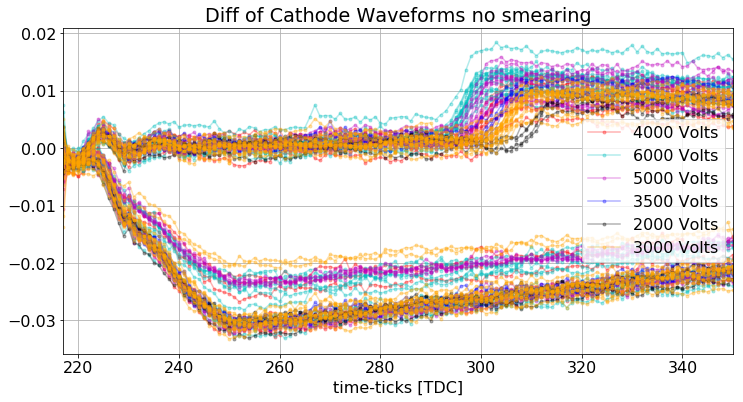

In [50]:
color_v = ['r','c','m','b','k','orange']

fig = plt.figure(figsize=(12,6))

voltage_v = []
slope_v = []
AGcrossing_v = []
Acrossing_v = []
CGcrossing_v = []
Ccrossing_v = []

tmax_by_voltage = {}
AG_A_drift_by_voltage = {}
C_CG_drift_by_voltage = {}
CG_AG_drift_by_voltage = {}

ctr = 0
for voltage,waveformsA in WF_A_D.items():
    
    waveformsC = WF_C_D[voltage]
    
    wfctr = 0
    
    for i, waveformA in enumerate(waveformsA):
        
        #print ("voltage : %i with waveform %i"%(voltage,i))
        #skip ugly wf
        if (voltage == 5000 and i == 11):
            continue
    
    
        waveformC = waveformsC[i]
        
        mincathode = np.min(waveformC)
        waveformAR = waveformA#/(-mincathode)
        #waveformAR = SMOOTH(waveformAR,10)
        waveformAR = diffwf(waveformAR)
        
        waveformCR = diffwf(waveformC)
        
        # find AG and A crossings
        AGcrossing = 0
        Acrossing = 0
        for tick in range(len(waveformAR)-1):
            if (tick < 280):
                continue
            ADC1 = waveformAR[tick]
            ADC2 = waveformAR[tick+1]
            if (AGcrossing == 0):
                if (ADC1 > 0.0005 and ADC2 > 0.0005):
                    AGcrossing = tick
            elif (AGcrossing > 0 and Acrossing == 0):
                if (ADC1 < 0.0005 and ADC2 < 0.0005):
                    Acrossing = tick
            else:
                break
                
        AGcrossing_v.append(AGcrossing)
        Acrossing_v.append(Acrossing)
        AGAtdrift = (Acrossing - AGcrossing) * 0.5 # us
        
        if voltage in AG_A_drift_by_voltage.keys():
            AG_A_drift_by_voltage[voltage].append(AGAtdrift)
        else:
            AG_A_drift_by_voltage[voltage] = [AGAtdrift]
        
        # find C and CG crossings
        CGcrossing = 0
        Ccrossing = 0
        for tick in range(len(waveformCR)-1):
            if (tick < 220):
                continue
            ADC1 = waveformCR[tick]
            ADC2 = waveformCR[tick+1]
            if (Ccrossing == 0):
                if (ADC1 < -0.0003 and ADC2 < -0.0003):
                    Ccrossing = tick
            elif (Ccrossing > 0 and CGcrossing == 0):
                if (ADC1 > -0.0003 and ADC2 > -0.0003):
                    CGcrossing = tick
            else:
                break
                
        CGcrossing_v.append(CGcrossing)
        Ccrossing_v.append(Ccrossing)
        CCGtdrift = (CGcrossing - Ccrossing) * 0.5 # us
        
        CGAGtdrift = (AGcrossing - CGcrossing) * 0.5
        
        if voltage in C_CG_drift_by_voltage.keys():
            C_CG_drift_by_voltage[voltage].append(CCGtdrift)
        else:
            C_CG_drift_by_voltage[voltage] = [CCGtdrift]
            
        if voltage in CG_AG_drift_by_voltage.keys():
            CG_AG_drift_by_voltage[voltage].append(CGAGtdrift)
        else:
            CG_AG_drift_by_voltage[voltage] = [CGAGtdrift]
                
        
        #if (np.max(waveformAR) > 0.003):
        #    continue

        
        #waveformAR = SMOOTH(waveformAR,10)
        
        #maxWF = np.max(waveformAR)
        #waveformAR /= maxWF
        
        # find tick where waveform passes value of 0.5
        #tickhalf = 0
        #maxval = 0
        #while maxval < 0.5:
        #    tickhalf += 1
        #    maxval = waveformAR[tickhalf]
            
        # find slope using +5 and -5 points
        #slope_tick_v = waveformAR[tickhalf-5:tickhalf+5]
        #slope_xval_v = np.linspace(1,len(slope_tick_v),len(slope_tick_v))
        #slope, intercept, r_value, p_value, std_err = stats.linregress(slope_xval_v,slope_tick_v)
        voltage_v.append(voltage)
        #slope_v.append(slope)
        
        print ('here voltage is ',voltage)
        
        #if voltage in tmax_by_voltage.keys():
        #    tmax_by_voltage[voltage].append(tickhalf)
        #else:
        #    tmax_by_voltage[voltage] = [tickhalf]
            
        
        # find peak tick of anode waveform
        tickmax = np.argmax(waveformAR)
        Tm = 0
        TM = -1
        #Tm = tickmax - 50
        #TM = tickmax + 50
    
        # skip weird waveforms
        #if (np.average(waveformAR[-100:-1]) > 0.2):
        #    continue
        #if (np.average(waveformAR[-100:-1]) < -0.05):
        #    continue
    
        #print ('min cathode : %.03f'%mincathode)
    
        if (wfctr==0):
            wfctr += 1
            plt.plot(waveformA[Tm:TM],color=color_v[ctr],marker='.',alpha=0.3,label='%i Volts'%voltage)#,label='Cathode',alpha=0.5)
            plt.plot(waveformC[Tm:TM],color=color_v[ctr],marker='.',alpha=0.3)#,label='%i Volts'%voltage)#,label='Cathode',alpha=0.5)
        else:
            plt.plot(waveformA[Tm:TM],color=color_v[ctr],marker='.',alpha=0.3)#,label='Cathode',alpha=0.5)
            plt.plot(waveformC[Tm:TM],color=color_v[ctr],marker='.',alpha=0.3)#,label='Cathode',alpha=0.5)
            
    waveformsC = WF_C_D[2000]
    waveformsA = WF_A_D[2000]
    
    wfctr = 0
    
  
    ctr += 1

plt.grid()
#plt.ylim([-0.035,0.035])
#plt.ylim([-0.0002,0.0006])
#plt.ylim([-0.0022,0.001])
#plt.ylim([-0.0005,0.0005])
plt.xlim([217,350])
#plt.xlim([0,250])
plt.legend()
plt.xlabel('time-ticks [TDC]')
#plt.ylabel('Anode / Max Cathode Ampl.')
#plt.title('Diff of Anode Waveforms w/ 10-tick smoothing')
plt.title('Diff of Cathode Waveforms no smearing')
plt.show()

In [37]:
print (voltage_v)

[4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 3500, 3500, 3500, 3500, 3500, 2000, 2000, 2000, 2000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


[1.17647059 1.76470588 2.05882353 2.35294118 2.94117647 3.52941176]


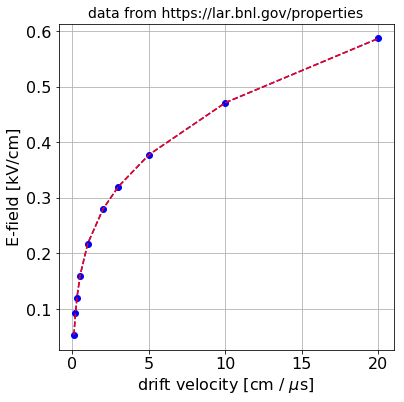

In [63]:
from scipy import interpolate

FIELD_V = [0.1,0.2,0.3,0.5,1.0,2.0,3.0,5.0,10.,20]
VEL_V = [0.0533,0.0922,0.1206,0.1601,0.2175,0.2797,0.320,0.3773,0.4710,0.5865]


fig = plt.figure(figsize=(6,6))
field_v = np.array([2,3,3.5,4,5,6])
dist = 1.7 # cm
VperCM = field_v/dist
print field_v/dist
drift_v = [0.2405,0.2794,0.2946,0.3081,0.3315,0.3514]
#plt.plot(VperCM,drift_v,'bo--')
plt.plot(FIELD_V,VEL_V,'bo--')

#func = interpolate.interp1d(VperCM,drift_v)
#xvals = np.arange(VperCM[0],VperCM[-1],0.1)
func2 = interpolate.interp1d(FIELD_V,VEL_V)
xvals = np.arange(FIELD_V[0],FIELD_V[-1],0.01)
yvals = func2(xvals)
plt.plot(xvals,yvals,'r--')

plt.grid()
plt.ylabel('E-field [kV/cm]')
plt.xlabel(r'drift velocity [cm / $\mu$s]')
plt.title('data from https://lar.bnl.gov/properties',fontsize=14)
plt.show()

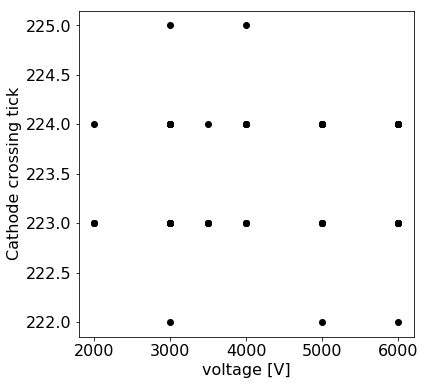

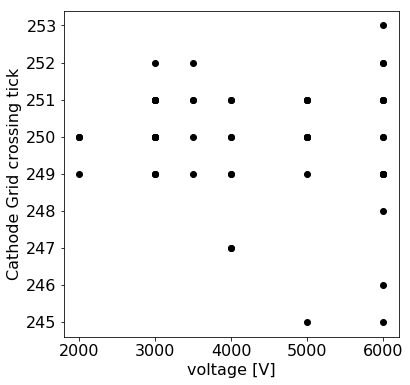

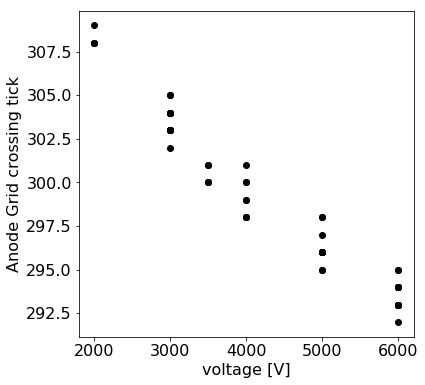

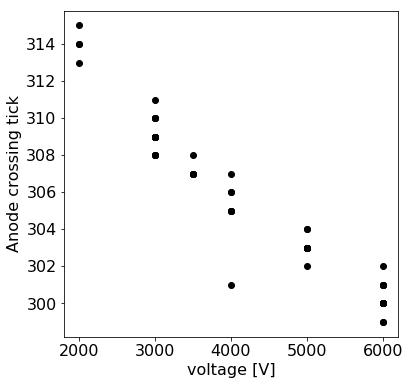

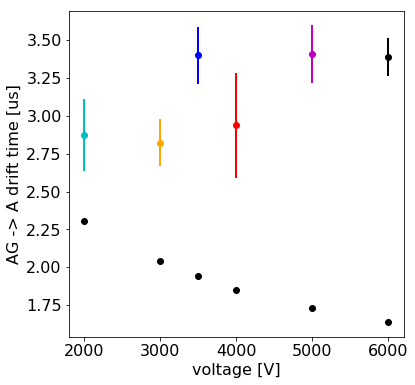

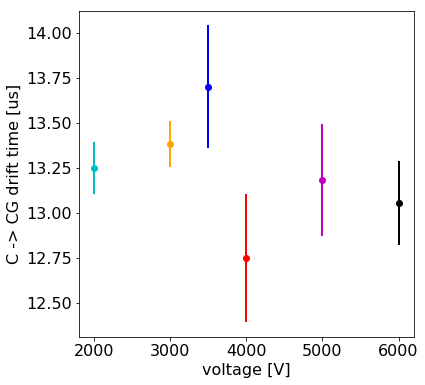

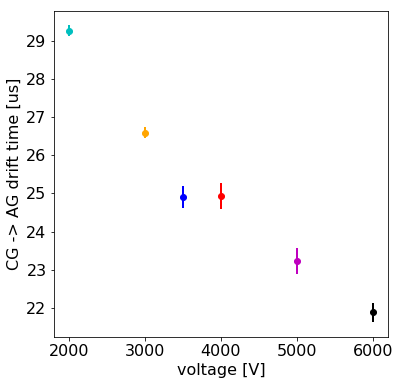

In [72]:
#fig = plt.figure(figsize=(6,6))
#plt.plot(voltage_v,slope_v,'ko')
#plt.xlabel('voltage [V]')
#plt.ylabel('Waveform Rise Slope [A.U.]')
#plt.show()

DIST_AG_A = 0.85
DIST_C_CG = 1.7
DIST_CG_AG = 0.85*3

fig = plt.figure(figsize=(6,6))
plt.plot(voltage_v,Ccrossing_v,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('Cathode crossing tick')
plt.show()
fig = plt.figure(figsize=(6,6))
plt.plot(voltage_v,CGcrossing_v,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('Cathode Grid crossing tick')
plt.show()
fig = plt.figure(figsize=(6,6))
plt.plot(voltage_v,AGcrossing_v,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('Anode Grid crossing tick')
plt.show()
fig = plt.figure(figsize=(6,6))
plt.plot(voltage_v,Acrossing_v,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('Anode crossing tick')
plt.show()

AGcrossing_v = np.array(AGcrossing_v)
Acrossing_v = np.array(Acrossing_v)
TDriftA = (Acrossing_v - AGcrossing_v) #* 0.5

fig = plt.figure(figsize=(6,6))
ctr = 0
efield_v = []
efield_raw_v = []
for key,vals in AG_A_drift_by_voltage.items():
    v = np.array(vals)
    efield_v.append(key/1000./(DIST_AG_A/2.))
    efield_raw_v.append(key)
    #print (' there are %i measurement for voltage %i'%(len(v),key))
    #print (v)
    MEAN = np.mean(v)
    ERR  = np.std(v) / np.sqrt(len(v)-1)
    plt.errorbar(key,MEAN,ERR,fmt='o',color=color_v[ctr],lw=2)
    ctr += 1
driftvel_v = func2(efield_v)
efield_v = np.array(efield_v) * 1000.
drifttime_v_AG_A = DIST_AG_A / driftvel_v 
plt.plot(efield_raw_v,drifttime_v_AG_A,'ko',label='8 mm AG -> A dist')
#plt.plot(efield_v,drifttime_v_AG_A,'ko',label='8 mm AG -> A dist')
plt.xlabel('voltage [V]')
plt.ylabel('AG -> A drift time [us]')
plt.show()


fig = plt.figure(figsize=(6,6))
ctr = 0
for key,vals in C_CG_drift_by_voltage.items():
    v = np.array(vals)
    #print (' there are %i measurement for voltage %i'%(len(v),key))
    #print (v)
    MEAN = np.mean(v)
    ERR  = np.std(v) / np.sqrt(len(v)-1)
    plt.errorbar(key,MEAN,ERR,fmt='o',color=color_v[ctr],lw=2)
    ctr += 1
#plt.plot(voltage_v,TDriftA,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('C -> CG drift time [us]')
plt.show()

fig = plt.figure(figsize=(6,6))
ctr = 0
for key,vals in CG_AG_drift_by_voltage.items():
    v = np.array(vals)
    #print (' there are %i measurement for voltage %i'%(len(v),key))
    #print (v)
    MEAN = np.mean(v)
    ERR  = np.std(v) / np.sqrt(len(v)-1)
    plt.errorbar(key,MEAN,ERR,fmt='o',color=color_v[ctr],lw=2)
    ctr += 1
#plt.plot(voltage_v,TDriftA,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('CG -> AG drift time [us]')
plt.show()

[1.17647059 1.76470588 2.05882353 2.35294118 2.94117647 3.52941176]


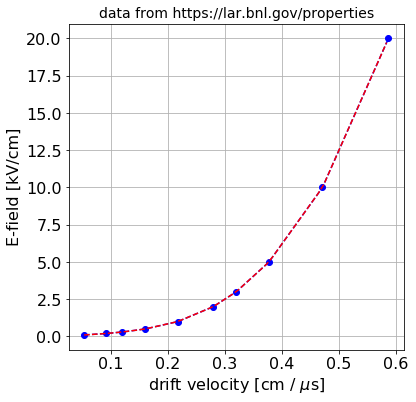

In [55]:
from scipy import interpolate

FIELD_V = [0.1,0.2,0.3,0.5,1.0,2.0,3.0,5.0,10.,20]
VEL_V = [0.0533,0.0922,0.1206,0.1601,0.2175,0.2797,0.320,0.3773,0.4710,0.5865]


fig = plt.figure(figsize=(6,6))
field_v = np.array([2,3,3.5,4,5,6])
dist = 1.7 # cm
VperCM = field_v/dist
print field_v/dist
drift_v = [0.2405,0.2794,0.2946,0.3081,0.3315,0.3514]
#plt.plot(VperCM,drift_v,'bo--')
plt.plot(VEL_V,FIELD_V,'bo--')

#func = interpolate.interp1d(VperCM,drift_v)
#xvals = np.arange(VperCM[0],VperCM[-1],0.1)
func = interpolate.interp1d(VEL_V,FIELD_V)
xvals = np.arange(VEL_V[0],VEL_V[-1],0.01)
yvals = func(xvals)
plt.plot(xvals,yvals,'r--')

plt.grid()
plt.ylabel('E-field [kV/cm]')
plt.xlabel(r'drift velocity [cm / $\mu$s]')
plt.title('data from https://lar.bnl.gov/properties',fontsize=14)
plt.show()

[0.18888889 0.28333333 0.425      0.28333333 0.56666667 0.28333333
 0.34       0.2125    ]
[0.24285714 0.34       0.28333333 0.34      ]
[0.34       0.24285714 0.2125     0.28333333 0.34       0.28333333
 0.24285714 0.24285714 0.24285714 0.18888889 0.2125    ]
[0.2125     0.24285714 0.24285714 0.28333333 0.28333333]
[0.34       0.28333333 0.24285714 0.24285714 0.2125     0.24285714
 0.24285714 0.28333333 0.2125     0.18888889 0.2125     0.24285714
 0.24285714 0.24285714 0.28333333 0.28333333 0.28333333 0.34      ]
[0.425      0.34       0.24285714 0.34       0.34       0.28333333
 0.34       0.24285714 0.28333333 0.28333333 0.28333333 0.2125
 0.28333333 0.24285714 0.425      0.56666667 0.28333333]


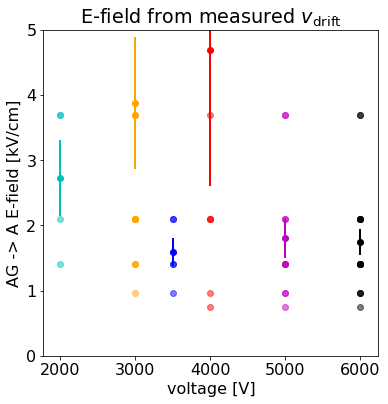

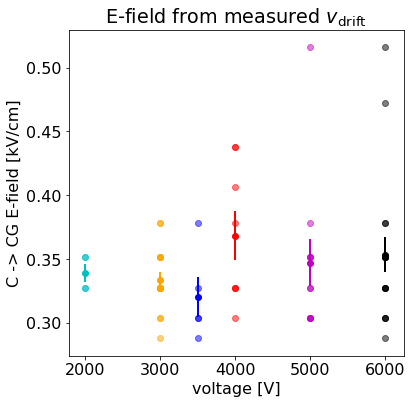

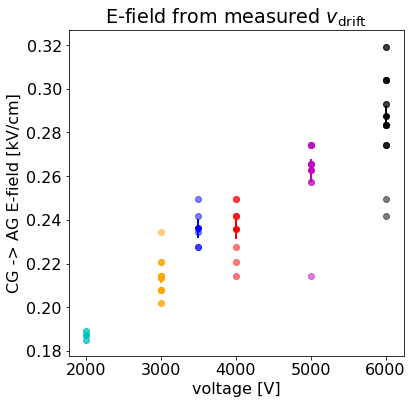

In [61]:
DIST_AG_A = 0.85
DIST_C_CG = 1.7
DIST_CG_AG = 0.85*3

fig = plt.figure(figsize=(6,6))
ctr = 0

field_v = []

for key,vals in AG_A_drift_by_voltage.items():
    v = DIST_AG_A / np.array(vals)
    field_v.append(key/1000.)
    print (v)
    ef = func(v)
    #print (' there are %i measurement for voltage %i'%(len(v),key))
    #print (v)
    MEAN = np.mean(ef)
    ERR  = np.std(ef) / np.sqrt(len(ef)-1)
    plt.errorbar(key,MEAN,ERR,fmt='o',color=color_v[ctr],lw=2)
    plt.scatter(np.ones(len(ef))*key,ef,marker='o',color=color_v[ctr],lw=1,alpha=0.5)
    ctr += 1
    

    
#plt.plot(voltage_v,TDriftA,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('AG -> A E-field [kV/cm]')
plt.title(r'E-field from measured $v_{\rm drift}$')
plt.ylim([0,5])
plt.show()


fig = plt.figure(figsize=(6,6))
ctr = 0
for key,vals in C_CG_drift_by_voltage.items():
    v = DIST_C_CG / np.array(vals)
    ef = func(v)
    #print (' there are %i measurement for voltage %i'%(len(v),key))
    #print (v)
    MEAN = np.mean(ef)
    ERR  = np.std(ef) / np.sqrt(len(ef)-1)
    plt.errorbar(key,MEAN,ERR,fmt='o',color=color_v[ctr],lw=2)
    plt.scatter(np.ones(len(ef))*key,ef,marker='o',color=color_v[ctr],lw=1,alpha=0.5)
    ctr += 1
#plt.plot(voltage_v,TDriftA,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('C -> CG E-field [kV/cm]')
plt.title(r'E-field from measured $v_{\rm drift}$')
plt.show()

fig = plt.figure(figsize=(6,6))
ctr = 0
for key,vals in CG_AG_drift_by_voltage.items():
    v = DIST_CG_AG / np.array(vals)
    #print (' there are %i measurement for voltage %i'%(len(v),key))
    #print (v)
    ef = func(v)
    MEAN = np.mean(ef)
    ERR  = np.std(ef) / np.sqrt(len(ef)-1)
    plt.errorbar(key,MEAN,ERR,fmt='o',color=color_v[ctr],lw=2)
    plt.scatter(np.ones(len(ef))*key,ef,marker='o',color=color_v[ctr],lw=1,alpha=0.5)
    ctr += 1
#plt.plot(voltage_v,TDriftA,'ko')
plt.xlabel('voltage [V]')
plt.ylabel('CG -> AG E-field [kV/cm]')
plt.title(r'E-field from measured $v_{\rm drift}$')
plt.show()

('drift-vel : ', array([], dtype=float64))
('tick max : ', array([], dtype=float64))
('voltage : ', array([], dtype=float64))


IndexError: tuple index out of range

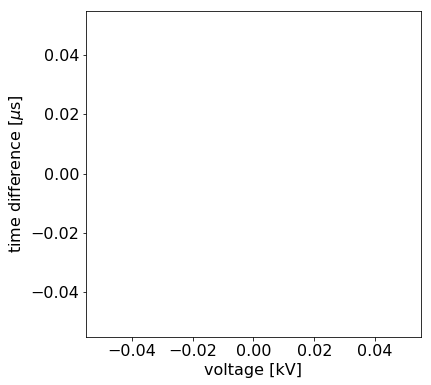

In [48]:
voltage_v = []
tickmax_avg_v = []
tickmax_std_v = []
driftvel_v  = [] # cm/us


for key, val in tmax_by_voltage.items():
    print key
    print val
    
    arr = np.array(val)
    
    mean = np.mean(arr)
    std  = np.std(arr)
    
    voltage_v.append(key)
    tickmax_avg_v.append(mean)
    tickmax_std_v.append(std)
    
    if (key == 2000):
        driftvel_v.append(0.31)
    if (key == 3000):
        driftvel_v.append(0.35)
    if (key == 3500):
        driftvel_v.append(0.37)
    if (key == 4000):
        driftvel_v.append(0.39)
    if (key == 5000):
        driftvel_v.append(0.41)
    if (key == 6000):
        driftvel_v.append(0.44)
    
voltage_v = np.array(voltage_v)
tickmax_avg_v = np.array(tickmax_avg_v)
tickmax_std_v = np.array(tickmax_std_v)
driftvel_v = np.array(driftvel_v)

print ('drift-vel : ',driftvel_v)
print ('tick max : ',tickmax_avg_v)
print ('voltage : ',voltage_v)

# delta-drift-time = drift distance x [dv] / [v1 * v2] 
# v1 is the drift velocity at current field
# v2 is drift velocity at reference (2kv)
# dv is the difference in drift velocities

delta_driftvel_v = driftvel_v - 0.31
driftvel_prod_v = 0.31 * driftvel_v

delta_time_theory_v = 0.85 * (delta_driftvel_v / driftvel_prod_v)

tickmax_avg_v *= 0.5 # us
tickmax_std_v *= 0.5 # us

time_reference = 0
for i,v in enumerate(voltage_v):
    if (v == 2000):
        time_reference = tickmax_avg_v[i]
        break

delta_time_measured_v = time_reference - tickmax_avg_v

fig = plt.figure(figsize=(6,6))
plt.plot(voltage_v,delta_time_theory_v,'bo',label='expected $\Delta$t [d = 0.85 cm]')
plt.errorbar(voltage_v,delta_time_measured_v,yerr=tickmax_std_v,fmt='o',color='r',label='measured $\Delta$t')
plt.xlabel('voltage [kV]')
plt.ylabel('time difference [$\mu$s]')
plt.legend()
plt.show()

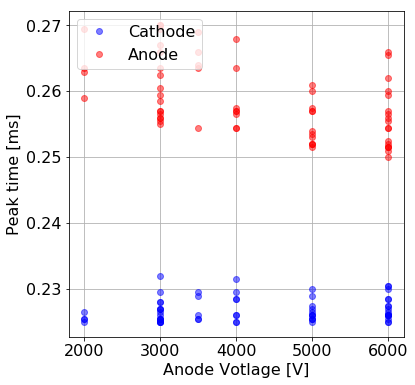

('# of entries: ', 64)


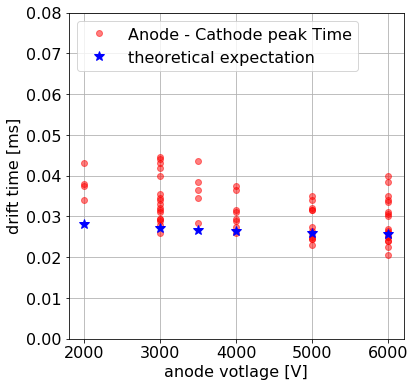

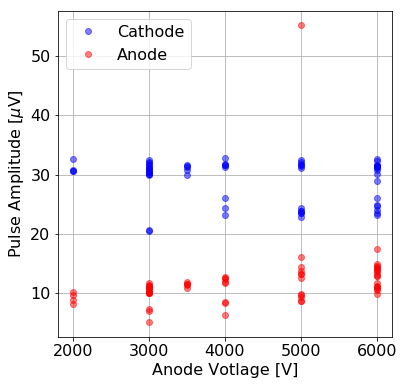

('# of entries: ', 64)


/home/david/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


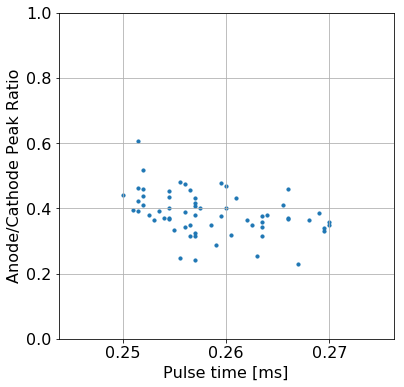

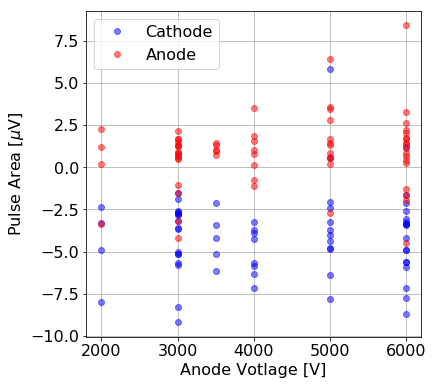

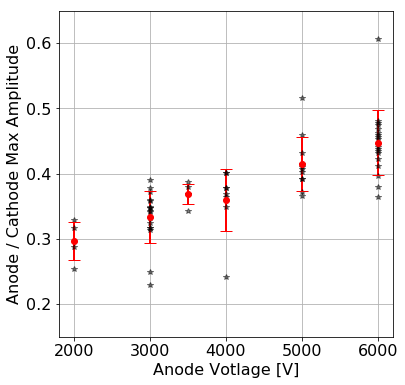

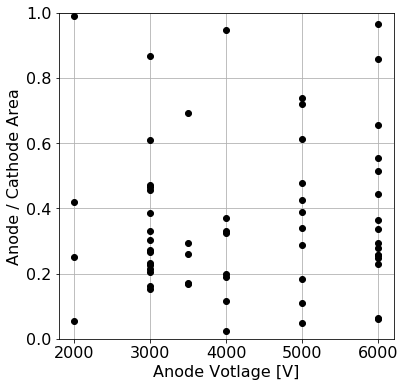

In [24]:
fig = plt.figure(figsize=(6,6))
plt.plot(VOLTAGE_V,CATHODE_T,'bo',label='Cathode',alpha=0.5)
plt.plot(VOLTAGE_V,ANODE_T,'ro',label='Anode',alpha=0.5)
plt.grid()
plt.xlabel('Anode Votlage [V]')
plt.ylabel('Peak time [ms]')
plt.legend(loc=2,fontsize=16)
plt.show()
print ('# of entries: ',len(ANODE_T))
TDIFF = np.array(ANODE_T)-np.array(CATHODE_T)

# theoretical calculation [from next cell]
field_v = np.array([2,3,3.5,4,5,6])
field_v = field_v * 1e3
drift_vel = np.array([0.2405,0.2794,0.2946,0.3081,0.3315,0.3514])
drift_time = 0.02064 + 1e-3 * (1.8 / drift_vel)

fig = plt.figure(figsize=(6,6))
#plt.plot(VOLTAGE_V,CATHODE_T,'bo',label='Cathode',alpha=0.5)
plt.plot(VOLTAGE_V,TDIFF,'ro',label='Anode - Cathode peak Time',alpha=0.5)
plt.plot(field_v,drift_time,'b*',markersize=10,label='theoretical expectation')
plt.grid()
plt.xlabel('anode votlage [V]')
plt.ylabel('drift time [ms]')
plt.ylim([0.,0.08])
plt.legend(loc=2,fontsize=16)
plt.show()


fig = plt.figure(figsize=(6,6))
plt.plot(VOLTAGE_V,CATHODE_V,'bo',label='Cathode',alpha=0.5)
plt.plot(VOLTAGE_V,ANODE_V,'ro',label='Anode',alpha=0.5)
'''
for v,a_v in ANODE_V_D.items():
    a_v_np = np.array(a_v)
    median = np.median(a_v_np)
    rms    = np.std(a_v_np)
    plt.errorbar(v,median,yerr=rms,color='orange',fmt='*',lw=2,markersize=12)
for v,c_v in CATHODE_V_D.items():
    c_v_np = np.array(c_v)
    median = np.median(c_v_np)
    rms    = np.std(c_v_np)
    plt.errorbar(v,median,yerr=rms,color='cyan',fmt='*',lw=2,markersize=12)
'''
plt.grid()
plt.ylabel(r'Pulse Amplitude [$\mu$V]')
plt.xlabel('Anode Votlage [V]')
plt.legend(loc=2,fontsize=16)
plt.show()


fig = plt.figure(figsize=(6,6))
print ('# of entries: ',len(ANODE_T))
#plt.scatter(ANODE_T,CATHODE_V,'bo',label='Cathode',alpha=0.5)
plt.scatter(ANODE_T,ANODE_V/CATHODE_V,marker='o',s=10,alpha=1.0)
plt.grid()
plt.xlabel('Pulse time [ms]')
plt.ylabel(r'Anode/Cathode Peak Ratio')
#plt.xlabel('Anode Votlage [V]')
plt.legend(loc=2,fontsize=16)
plt.ylim([0,1])
plt.show()

fig = plt.figure(figsize=(6,6))
plt.plot(VOLTAGE_V,CATHODE_A,'bo',label='Cathode',alpha=0.5)
plt.plot(VOLTAGE_V,ANODE_A,'ro',label='Anode',alpha=0.5)
'''
for v,a_v in ANODE_A_D.items():
    a_v_np = np.array(a_v)
    median = np.median(a_v_np)
    rms    = np.std(a_v_np)
    plt.errorbar(v,median,yerr=rms,color='orange',fmt='*',lw=2,markersize=12)
for v,c_v in CATHODE_A_D.items():
    c_v_np = np.array(c_v)
    median = -np.median(c_v_np)
    rms    = np.std(c_v_np)
    plt.errorbar(v,median,yerr=rms,color='cyan',fmt='*',lw=2,markersize=12)
'''
plt.grid()
plt.ylabel(r'Pulse Area [$\mu$V]')
plt.xlabel('Anode Votlage [V]')
plt.legend(loc=2,fontsize=16)
plt.show()


AMPL_RATIO_DICT = {}
for i,v in enumerate(VOLTAGE_V):
    a = ANODE_V[i]
    c = CATHODE_V[i]
    if v in AMPL_RATIO_DICT:
        ratio = a/c
        if (ratio > 1. or ratio < 0.): continue
        AMPL_RATIO_DICT[v].append(ratio)
    else:
        AMPL_RATIO_DICT[v] = [a/c]
fig = plt.figure(figsize=(6,6))
plt.plot(VOLTAGE_V,ANODE_V/CATHODE_V,'k*',markersize=6,alpha=0.5)
for voltage,vals in AMPL_RATIO_DICT.items():
    arr = np.array(vals)
    mean = np.average(arr)
    std  = np.std(arr)
    plt.errorbar(voltage,mean,yerr=std,fmt='o',color='r',lw=2,capsize=6)
plt.grid()
plt.ylabel('Anode / Cathode Max Amplitude')
plt.xlabel('Anode Votlage [V]')
plt.ylim([0.15,0.65])
plt.legend(loc=2,fontsize=16)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.plot(VOLTAGE_V,np.abs(ANODE_A/CATHODE_A),'ko')
plt.grid()
plt.ylabel('Anode / Cathode Area')
plt.xlabel('Anode Votlage [V]')
plt.ylim([0,1])
plt.legend(loc=2,fontsize=16)
plt.show()

[1.17647059 1.76470588 2.05882353 2.35294118 2.94117647 3.52941176]


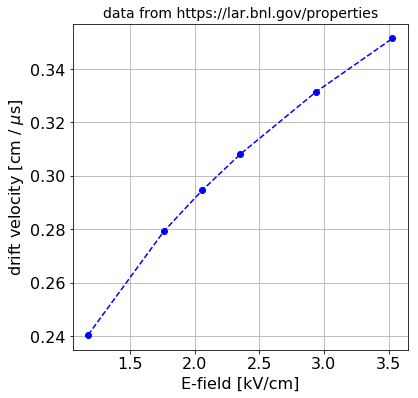

In [25]:
fig = plt.figure(figsize=(6,6))
field_v = np.array([2,3,3.5,4,5,6])
dist = 1.7 # cm
print field_v/dist
drift_v = [0.2405,0.2794,0.2946,0.3081,0.3315,0.3514]
plt.plot(field_v/dist,drift_v,'bo--')
plt.grid()
plt.xlabel('E-field [kV/cm]')
plt.ylabel(r'drift velocity [cm / $\mu$s]')
plt.title('data from https://lar.bnl.gov/properties',fontsize=14)
plt.show()